# **Experiment Objectives and Hypotheses**

## **Hypotheses:**



*   H1: Training separate regression models for each of the three identified clusters will improve performance (RMSE, MAE, R²) over a single unified model.

* H2: Clustering using Mahalanobis distance will yield more effective segments for modeling than Euclidean distance.

* H3: Training separate models for each season (Spring, Summer, Fall, Winter) will improve predictive accuracy by capturing seasonal variation in bike rental behavior.

* H4: Neural Network outperforms our baseline




## **Research Questions:**
* RQ1: Does cluster-based modeling improve regression performance compared to a single global model?

* RQ2: Which clustering distance metric (Mahalanobis vs. Euclidean) produces better downstream model performance?

* RQ3: Can season-specific models capture trends in bike demand better than a unified model?

* RQ4: Among XGBoost, neural networks, and cluster-wise regressors, which method yields the best performance?



## **Experimental Design:**
### Baseline Model:
XG Boost
### Target Variable:
Rented Bike Count
### Dataset:
Seoul Bike Sharing Demand
### Data Split:
80% training, 20% testing

### Method:
[Insert a brief description of your method here]

### Visualization:

[Insert if applicable]


### Performance Metrics:
RMSE, MAE, and R²

## **Expected Outcomes:**


*  [Insert expectations from experiments]
*  [Insert expectations from experiments]




# **Import Libraries**

include additional libraries for development in this section

In [1]:
pip install ucimlrepo


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
!pip install statsmodels==0.14.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 115.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 58.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['xtick.color'] = '#333333'
mpl.rcParams['ytick.color'] = '#333333'

2025-05-31 14:14:01.042641: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-31 14:14:01.047347: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-31 14:14:01.099022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-31 14:14:01.099120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-31 14:14:01.100113: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# **Import Data**

In [13]:
# Fetch Seoul Bike Sharing Demand dataset from UCI ML Repository
seoul_bike_sharing_demand = fetch_ucirepo(id=560)

In [22]:
# Data (as pandas dataframes)
X_original = seoul_bike_sharing_demand.data.features
y_original = seoul_bike_sharing_demand.data.targets

In [25]:
# Print dataset information
print("Dataset Metadata:")
print(seoul_bike_sharing_demand.metadata)
print("\nVariable Information:")
print(seoul_bike_sharing_demand.variables)

Dataset Metadata:
{'uci_id': 560, 'name': 'Seoul Bike Sharing Demand', 'repository_url': 'https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand', 'data_url': 'https://archive.ics.uci.edu/static/public/560/data.csv', 'abstract': 'The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information', 'area': 'Business', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 8760, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Functioning Day'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Mon Feb 05 2024', 'dataset_doi': '10.24432/C5F62R', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bi

In [28]:
# Examine feature information
print("\nOriginal feature columns:")
print(X_original.columns.tolist())
print("\nOriginal target variable:")
print(y_original.columns.tolist())


Original feature columns:
['Date', 'Rented Bike Count', 'Hour', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 'Dew point temperature', 'Solar Radiation', 'Rainfall', 'Snowfall', 'Seasons', 'Holiday']

Original target variable:
['Functioning Day']


# **Data Preprocessing**

**Data Preprocessing Steps**



*   Makes "Rented Bike Count" new target. Move former target from dataset api to features
*   Check for missing values
*  Transform date column to date time
*  Transform categorical features using one hot encoding
* Split dataset into test (80%) and training (20%)
* Create heatmap to identify correlated features
* Compute VIF (Variance Inflation Factor) to measure multicolinearity
* Define function to remove colinear features using a 0.8 Colinearity threshold
* Compare VIF before and after removal





In [31]:
# Make 'Rented Bike Count' the new target if it exists

if 'Rented Bike Count' in X_original.columns:
    # Make 'Rented Bike Count' the new target
    y = X_original[['Rented Bike Count']]
    # Remove 'Rented Bike Count' from features
    X = X_original.drop('Rented Bike Count', axis=1)
    # Add original target to features
    X = pd.concat([X, y_original], axis=1)

else:
    # If 'Rented Bike Count' is already the target, just confirm
    print("'Rented Bike Count' is already the target variable.")
    y = y_original
    X = X_original

In [34]:
print("\nNew feature columns:")
print(X.columns.tolist())
print("\nNew target variable:")
print(y.columns.tolist())


New feature columns:
['Date', 'Hour', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 'Dew point temperature', 'Solar Radiation', 'Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'Functioning Day']

New target variable:
['Rented Bike Count']


In [37]:
# Check for missing values
print("\nMissing values in features:")
print(X.isnull().sum())
print("\nMissing values in target:")
print(y.isnull().sum())


Missing values in features:
Date                        0
Hour                        0
Temperature                 0
Humidity                    0
Wind speed                  0
Visibility                  0
Dew point temperature       0
Solar Radiation             0
Rainfall                    0
Snowfall                    0
Seasons                     0
Holiday                     0
Functioning Day          8760
dtype: int64

Missing values in target:
Rented Bike Count    0
dtype: int64


In [40]:
# 1. Convert date column to datetime and extract useful components. date format is DD/MM/YYYY
if 'Date' in X.columns:
    # Specify the correct date format as DD/MM/YYYY
    X['Date'] = pd.to_datetime(X['Date'], format='%d/%m/%Y')
    X['Year'] = X['Date'].dt.year
    X['Month'] = X['Date'].dt.month
    X['Day'] = X['Date'].dt.day
    X['DayOfWeek'] = X['Date'].dt.dayofweek
    X = X.drop('Date', axis=1)

In [43]:
# 2. Convert categorical features to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

In [46]:
X

,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Year,Month,Day,DayOfWeek,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday
0,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,2017,12,1,4,False,False,True,True
1,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,2017,12,1,4,False,False,True,True
2,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,2017,12,1,4,False,False,True,True
3,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,2017,12,1,4,False,False,True,True
4,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,2017,12,1,4,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,2018,11,30,4,False,False,False,True
8756,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,2018,11,30,4,False,False,False,True
8757,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,2018,11,30,4,False,False,False,True
8758,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,2018,11,30,4,False,False,False,True


In [49]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

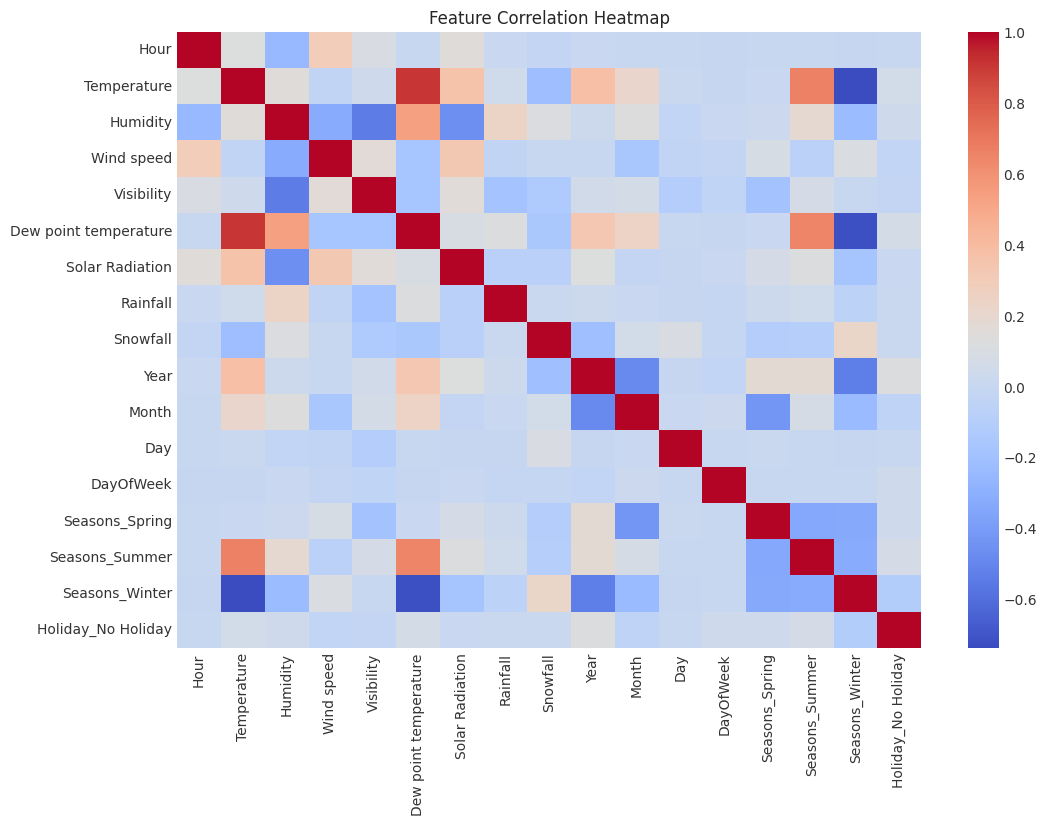

In [52]:
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)

correlation_matrix = X_train_df.corr()

plt.figure(figsize=(12, 8))
# Use the calculated correlation matrix in the heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

In [55]:
# Function to calculate VIF (Variance Inflation Factor)
def calculate_vif(X):
    # Select only numeric columns to avoid issues with non-numeric data types
    X_numeric = X.select_dtypes(include=np.number)
    # Drop columns with any non-finite values if they exist (though the type error suggests something else)
    # X_numeric = X_numeric.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

    # Check if there are still columns left
    if X_numeric.shape[1] == 0:
        print("Warning: No numeric columns found for VIF calculation.")
        return pd.DataFrame(columns=["feature", "VIF"])

    vif_data = pd.DataFrame()
    vif_data["feature"] = X_numeric.columns
    # Ensure the values passed to variance_inflation_factor are finite and the correct type
    vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
    return vif_data.sort_values("VIF", ascending=False)

# Function to remove collinear features based on correlation threshold
def remove_collinear_features(X, threshold=0.8):
    # Select only numeric columns before calculating correlation
    X_numeric = X.select_dtypes(include=np.number)

    corr_matrix = X_numeric.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    plt.show()

    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(f"Dropping {len(to_drop)} collinear features: {', '.join(to_drop)}")

    # Return dataframe with collinear features removed (applied to original X)
    return X.drop(to_drop, axis=1)


Variance Inflation Factors before colinearity removal:
                  feature         VIF
9                    Year  400.077937
1             Temperature  187.639650
2                Humidity  185.135619
5   Dew point temperature  124.905908
4              Visibility   10.741240
10                  Month    5.127716
3              Wind speed    4.870599
0                    Hour    4.490694
11                    Day    4.365954
12              DayOfWeek    3.316688


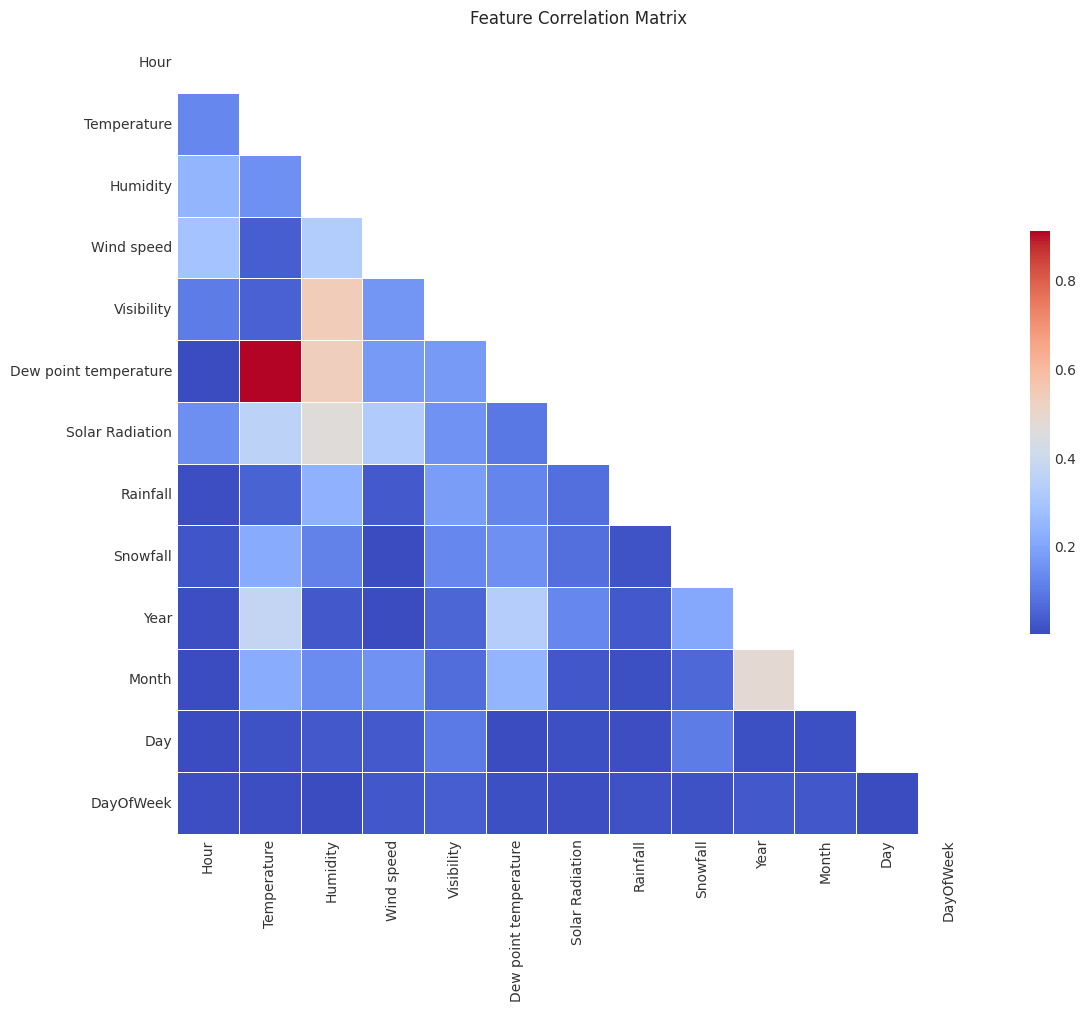

Dropping 1 collinear features: Dew point temperature

Variance Inflation Factors after collinearity removal:
            feature        VIF
8              Year  65.515521
2          Humidity  23.627670
4        Visibility  10.684063
9             Month   5.127686
3        Wind speed   4.862055
0              Hour   4.481881
10              Day   4.365509
1       Temperature   3.659379
11        DayOfWeek   3.293785
5   Solar Radiation   2.770306


In [58]:
# Calculate VIF before feature removal
print("Variance Inflation Factors before colinearity removal:")
# Ensure only numeric columns are passed to calculate_vif
X_train_numeric = X_train.select_dtypes(include=np.number)
vif_before = calculate_vif(X_train_numeric)
print(vif_before.head(10))  # Show top 10 highest VIF values

# Remove collinear features
# The remove_collinear_features function now handles numeric selection internally for correlation
X_train_filtered = remove_collinear_features(X_train, threshold=0.8)
# Ensure test set has the same columns as the filtered training set
X_test_filtered = X_test[X_train_filtered.columns]

# Calculate VIF after feature removal
print("\nVariance Inflation Factors after collinearity removal:")
# Ensure only numeric columns are passed to calculate_vif
X_train_filtered_numeric = X_train_filtered.select_dtypes(include=np.number)
vif_after = calculate_vif(X_train_filtered_numeric)
print(vif_after.head(10))

In [61]:
# Standardize the filtered features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

# **Baseline Model Development**

In [74]:
!pip install xgboost==3.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 2.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [78]:
# Import the XGBoost library
import xgboost as xgb

# Baseline XGBoost model
print("Training baseline XGBoost regression model...")
baseline_model = xgb.XGBRegressor(random_state=42)
baseline_model.fit(X_train_scaled, y_train.values.ravel())
baseline_preds = baseline_model.predict(X_test_scaled)
baseline_metrics = {
    'rmse': math.sqrt(mean_squared_error(y_test, baseline_preds)),
    'r2': r2_score(y_test, baseline_preds)
}

Training baseline XGBoost regression model...


# **Model Development - Neural Network**

In [81]:
# Build a Neural Network model
print("Training Neural Network model...")

# Define the neural network architecture
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate the model
nn_preds = nn_model.predict(X_test_scaled)
nn_metrics = {
    'rmse': math.sqrt(mean_squared_error(y_test, nn_preds)),
    'r2': r2_score(y_test, nn_preds)
}

print("Neural Network Model Performance:")
print(f"RMSE: {nn_metrics['rmse']}")
print(f"R²: {nn_metrics['r2']}")

Training Neural Network model...
Epoch 1/50
176/176 [==============================] - 1s 2ms/step - loss: 606378.1250 - mae: 539.1385 - val_loss: 217506.4844 - val_mae: 331.2969
Epoch 2/50
176/176 [==============================] - 0s 2ms/step - loss: 207534.9219 - mae: 320.7397 - val_loss: 197218.0156 - val_mae: 314.3114
Epoch 3/50
176/176 [==============================] - 0s 2ms/step - loss: 200029.9844 - mae: 310.2031 - val_loss: 193543.7344 - val_mae: 310.1326
Epoch 4/50
176/176 [==============================] - 0s 2ms/step - loss: 196308.9531 - mae: 306.2451 - val_loss: 190404.5469 - val_mae: 305.8921
Epoch 5/50
176/176 [==============================] - 0s 2ms/step - loss: 193530.8125 - mae: 303.3931 - val_loss: 187591.1875 - val_mae: 302.4887
Epoch 6/50
176/176 [==============================] - 0s 2ms/step - loss: 191615.5938 - mae: 300.5646 - val_loss: 188310.8438 - val_mae: 304.4897
Epoch 7/50
176/176 [==============================] - 0s 2ms/step - loss: 189448.8438 - mae

### Model Development - Random Forest

In [84]:
from sklearn.ensemble import RandomForestRegressor

# Build a Random Forest model
print("Training Random Forest regression model...")
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train.values.ravel())
rf_preds = rf_model.predict(X_test_scaled)
rf_metrics = {
    'rmse': math.sqrt(mean_squared_error(y_test, rf_preds)),
    'r2': r2_score(y_test, rf_preds)
}

print("Random Forest Model Performance:")
print(f"RMSE: {rf_metrics['rmse']}")
print(f"R²: {rf_metrics['r2']}")

Training Random Forest regression model...
Random Forest Model Performance:
RMSE: 237.38627544328594
R²: 0.8647479836160911


The Random Forest model has been trained successfully. It achieved an RMSE of 237.39 and an R² of 0.865.

# **Evaluation and Visualizations**

Text(2, 191.40947923000624, 'Best: 191.91')

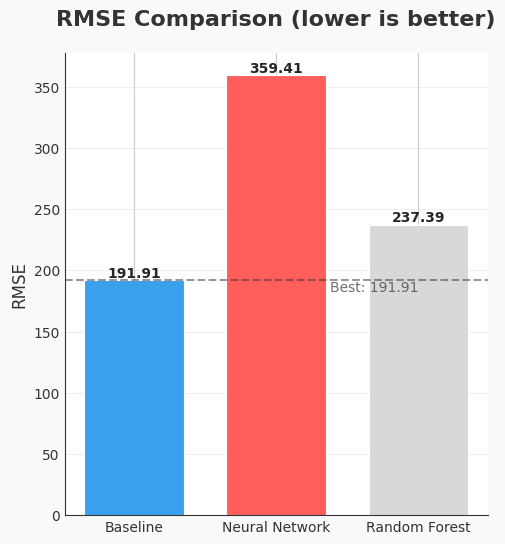

In [93]:
# Create a bar chart comparing the metrics
plt.figure(figsize=(12, 6))
plt.gcf().patch.set_facecolor('#f8f9fa')  # Use plt.gcf() to get the current figure

# Define the colors from our palette
colors = ['#39A0ED', '#FF5E5B', '#D8D8D8']  # Blue, Coral, Light Gray

# RMSE comparison (lower is better)
plt.subplot(1, 2, 1)
models = ['Baseline', 'Neural Network', 'Random Forest']
rmse_values = [baseline_metrics['rmse'], nn_metrics['rmse'], rf_metrics['rmse']]
bars = plt.bar(models, rmse_values, color=colors,
               edgecolor='white', linewidth=0.8, width=0.7)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

plt.title('RMSE Comparison (lower is better)', fontsize=16, pad=20, fontweight='bold', color='#333333')
plt.ylabel('RMSE', fontsize=12, color='#333333')
plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

min_rmse = min(rmse_values)
plt.axhline(y=min_rmse, color='#333333', linestyle='--', alpha=0.5)
plt.text(len(models)-1, min_rmse-0.5, f'Best: {min_rmse:.2f}',
         ha='right', va='top', color='#333333', alpha=0.7)

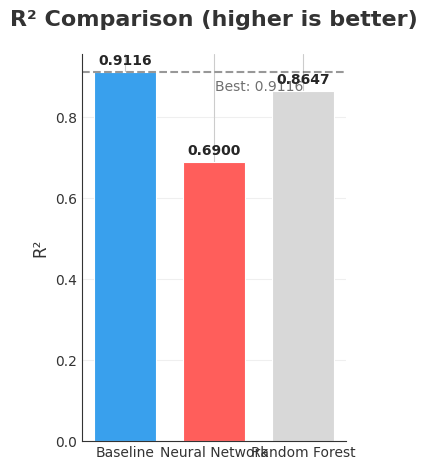

In [96]:
# R² comparison (higher is better)
plt.subplot(1, 2, 2)
r2_values = [baseline_metrics['r2'], nn_metrics['r2'], rf_metrics['r2']]
bars = plt.bar(models, r2_values, color=colors,  # Using the same color palette
               edgecolor='white', linewidth=0.8, width=0.7)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Customize appearance
plt.title('R² Comparison (higher is better)', fontsize=16, pad=20, fontweight='bold', color='#333333')
plt.ylabel('R²', fontsize=12, color='#333333')
plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add a horizontal line at the maximum R² for reference
max_r2 = max(r2_values)
plt.axhline(y=max_r2, color='#333333', linestyle='--', alpha=0.5)
plt.text(len(models)-1, max_r2-0.02, f'Best: {max_r2:.4f}',
         ha='right', va='top', color='#333333', alpha=0.7)

plt.tight_layout()
plt.savefig('seoul_bike_metrics_comparison.png', dpi=300, bbox_inches='tight', facecolor='#f8f9fa')
plt.show()

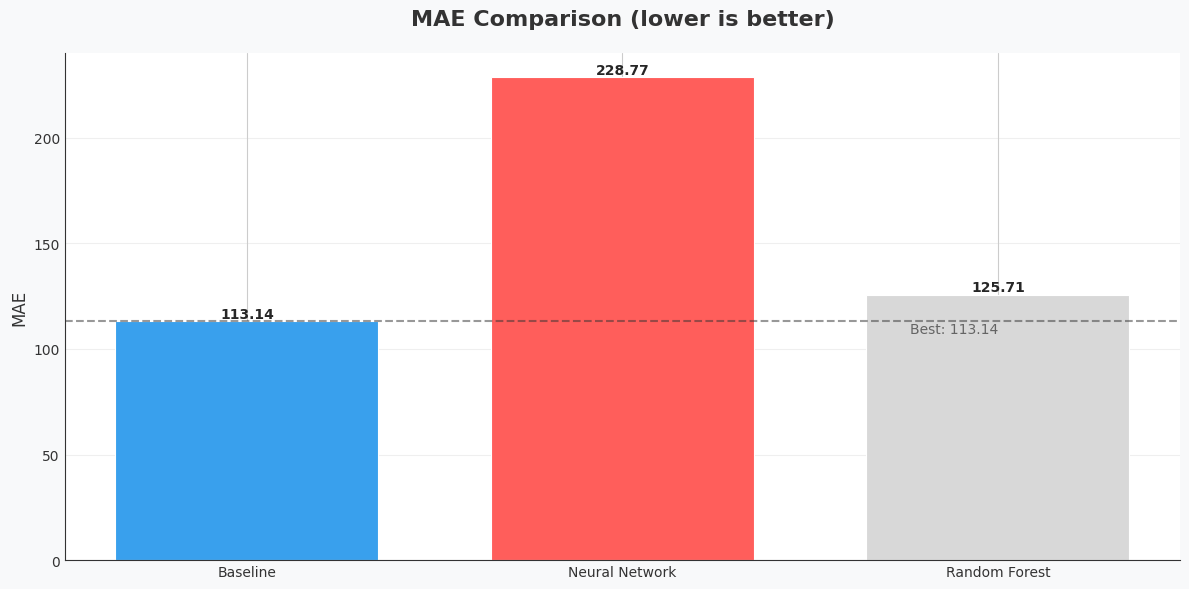

In [99]:
# MAE comparison (lower is better)
plt.figure(figsize=(12, 6))
plt.gcf().patch.set_facecolor('#f8f9fa')  # Set background color

# Calculate MAE for each model
from sklearn.metrics import mean_absolute_error
baseline_mae = mean_absolute_error(y_test, baseline_preds)
nn_mae = mean_absolute_error(y_test, nn_preds)
rf_mae = mean_absolute_error(y_test, rf_preds)

# Define models and their MAE values
models = ['Baseline', 'Neural Network', 'Random Forest']
mae_values = [baseline_mae, nn_mae, rf_mae]

# Define the colors from our palette
colors = ['#39A0ED', '#FF5E5B', '#D8D8D8']  # Blue, Coral, Light Gray

# Create the bar chart
bars = plt.bar(models, mae_values, color=colors, edgecolor='white', linewidth=0.8, width=0.7)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

# Customize appearance
plt.title('MAE Comparison (lower is better)', fontsize=16, pad=20, fontweight='bold', color='#333333')
plt.ylabel('MAE', fontsize=12, color='#333333')
plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add a horizontal line at the minimum MAE for reference
min_mae = min(mae_values)
plt.axhline(y=min_mae, color='#333333', linestyle='--', alpha=0.5)
plt.text(len(models)-1, min_mae-0.5, f'Best: {min_mae:.2f}',
         ha='right', va='top', color='#333333', alpha=0.7)

plt.tight_layout()
plt.savefig('seoul_bike_mae_comparison.png', dpi=300, bbox_inches='tight', facecolor='#f8f9fa')
plt.show()

Experimental Design:
Baseline Model:
XG Boost

Target Variable:
Rented Bike Count

Dataset:
Seoul Bike Sharing Demand

Data Split:
80% training, 20% testing

Method:
We preprocessed the dataset by handling missing values, transforming the date column, and applying one-hot encoding for categorical variables. Features were standardized, and multicollinearity was addressed by removing highly correlated features based on a threshold of 0.8. Variance Inflation Factor (VIF) was calculated before and after feature removal to ensure reduced multicollinearity. Three models were trained: XGBoost (baseline), Neural Network, and Random Forest. Each model was evaluated on the test set using RMSE, MAE, and R² metrics.

Visualization:
Bar charts were created to compare RMSE, MAE, and R² metrics across the three models.

Performance Metrics:
RMSE, MAE, and R²

Expected Outcomes:
1. The baseline XGBoost model is expected to outperform the Random Forest model in terms of RMSE and R².
2. Neural Network is expected to show competitive performance but may require hyperparameter tuning for optimal results.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3dc2a452-943f-4fc3-b0c9-21a20bef01eb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>